# Dynamical systems with Python: Wilson and Cowan's model

Wilson and Cowan, in the seventies, developed a dynamical systems approach to the study of the large-scale behaviour of neuronal population. Their approach doesn't mind the behaviour of single neurons, but works at the level of population firing rates (roughly, the number of neurons that fire in the unit time) for two subpopulation: the inhibitory neurons and the excitatory neurons.

If you're interested in Wilson and Cowan's model, keep reading. If you came here to see some Python code, skip to the [numerical solution](#numerical).

## The theory

### Assumptions 

We are concerned only with the behaviour of **populations** rather than individual cells.

> The cells comprising such populations are assumed to be in close spatial proximity, and their interconnections are assumed to be random, yet dense enough so that it is very probable that there will be at least one path (either direct or via interneurons) connecting any two cells within the population. Under these conditions we may neglect spatial interactions and deal simply with the temporal dynamics of the aggregate. Consistent with this approach, we have chosen as the relevant variable the proportion of cells in the population which become active per unit time. [...]

> There is one final and crucial assumption upon which this study rests: *all nervous processes of any complexity are dependent upon the interaction of excitatory and inhibitory cells*.

Spatial interactions are discussed in a subsequent paper by the same authors.


### Getting to a system of equations

In the rest of the post, we will call $E(t)$ and $I(t)$ the istantaneous firing rates, at time $t$, of the excitatory and inhibitory populations respectively. The point $(E=0, I=0)$ should not be interpreted as the state where the activity is completely dead, but rather as the resting state of the network, as we will require it to be a stable fixed point.

To construct a meaningful model, we slowly incorporate the relevant biological assumptions. When does a neuron fire? In the simplest models, two conditions need to be fulfilled:
1. the neuron should *not* be in its "refractory period", that is, it can't fire again just after having fired;
2. it needs to have received sufficient input in a short interval of time.

##### Non-refractoriness
The fraction of excitatory neurons that fired between $t_1$ and $t_2$ is
$$ \int_{t_1}^{t_2} E(t')dt'. $$  
Therefore, if $r$ is the length of the refractory period, the fraction of neurons that satisfy condition 1 at time $t$ is:  
$$ 1 - \int_{t-r}^{t} E(t')dt' \quad\quad (1)$$  
and similarly for the inhibitory subpopulation.

##### Sufficient excitation
To see if condition 2 is fulfilled, we need the total input to the subpopulation, which is $c_1 E(t) - c_2 I(t) + P(t)$, i.e. a weighed contribution from the excitatory population, a corresponding negative contribution from the inhibitory neurons, and an external input $P$. Then, the neuron responds non-linearly to this input. We call $S_e$ the response function, also called the *input-frequency characteristic* of the excitatory neurons, and correspondingly $S_i$ for the inhibitory ones.  
Now, it's not only the instantaneous behaviour that counts: a spike can still help eliciting a new spike in a downstream neuron even a few milliseconds later. So the probability of being excited at time $t$ is proportional to
$$ S_e \left( \int_{-\infty}^t \alpha(t-t') [c_1 E(t') - c_2 I(t') + P(t')]dt' \right) \quad\quad (2)$$


##### Coarse graining
Both in (1) and (2) we can get rid of the integrals and multiply the stimulus by a constant describing the length of the time influence instead, if we are interested in the coarse grained temporal behaviour of the activity, i.e. we focus on variations at a timescale slightly longer than the refractory period $r$ and the "characteristic length", which we call $k$, of the function $\alpha$. So, finally, we can say the activity at time $d + dt$ depends on the simultaneous fulfillment of conditions (1) and (2):
$$ E(t + dt) = (1- rE(t))\, S_e(kc_1 E(t) - kc_2 I(t) + kP(t)) $$

<a id="numerical"></a>
### Wilson and Cowan's model, a final version

After all these approximations and assumptions, by turning the equation above in differential form and appropriately rescaling $S_e$, we reach a system of coupled, nonlinear, differential equation for the firing rates of the excitatory and inhibitory populations, which constitute the Wilson-Cowan model.

$$ \tau_e \frac{dE}{dt} = -E + (k_e - r_e E) \, S_e(c_1 E - c_2 I + P)$$
$$ \tau_i \frac{dI}{dt} = -I + (k_i - r_i I) \, S_i(c_3 E - c_4 I + Q),$$
where:
* $\tau_e$ and $\tau_i$ are time constants;
* $k_e$ and $k_i$ are adimensional constants
* $r_e$ and $r_i$ are constants describing the length of the refractory periods;
* $S_e$ and $S_i$ are sigmoid functions expressing the nonlinearity of the interactions;
* $c_{1,2,3,4}$ are parameters representing the strength of the excitatory to excitatory, inhibitory to excitatory, excitatory to inhibitory and inhibitory to inhibitory interactions;
* $P$ and $Q$ are external inputs to the two populations.

## Numerical solutions

Now, we want to numerically solve the [equations above](#numerical), regardless of their meaning. We will choose some values of their parameters, and some initial conditions, and plot the behaviour of the solution in the state space and in time.

In [1]:
# for fast array manipulation
import numpy as np
# for plotting
import matplotlib.pyplot as plt
# for numerical ODE integration
from scipy.integrate import odeint
# for nonlinear equations
from scipy.optimize import fsolve
# to display plots in-line
%matplotlib inline

### Parameter definitions
To represent the nonlinear behaviour of neurons, we use a sigmoid function, dependent on two parameters $a$ and $\theta$:

$$ S(x) = (1+e^{-a(x-\theta)})^{-1} $$

In [2]:
def sigmoid(x, a, thr):
    return 1 / (1 + np.exp(-a * (x - thr)))

##### For a stable limit cycle and a stable fixed point

In [3]:
# couplings
c1 = 16
c2 = 12
c3 = 15
c4 = 3

# refractory periods
rE = 1
rI = 1

# external inputs
P = 1.
Q = 1

# nonlinear functions
def Se(x):
    aE = 1.3
    thrE = 4
    return sigmoid(x, thrE, aE) - sigmoid(0, thrE, aE)

def Si(x):
    aI = 2
    thrI = 3.7
    return sigmoid(x, thrI, aI) - sigmoid(0, thrI, aI)

### More preparation

In [4]:
# this function returns the right hand side of the Wilson-Cowan equation
# (both, in a 2-vector)
def WilsonCowan(y, t):
    E = y[0]
    I = y[1]
    y1 = -E + (1 - rE * E) * Se(c1 * E - c2 * I + P)
    y2 = -I + (1 - rI * I) * Si(c3 * E - c4 * I + Q)
    return [y1, y2]

In [5]:
# minimum and maximum E and I values we want displayed in the graph
minval = -.1
maxval = .6
resolution = 50
# State variables
x1 = np.linspace(minval, maxval, resolution)
x2 = np.linspace(minval, maxval, resolution)
# Create a grid for evaluation of the vector field
x1, x2 = np.meshgrid(x1, x2)
# Evaluate the slopes
X1, X2 = WilsonCowan([x1, x2], 0)
# Compute the magnitude vector
M = np.hypot(X1, X2)
# Normalize the slopes vectors (for the field plot)
#X1, X2 = X1/M, X2/M

### Solving and plotting
#### Numerical search of stationary points

This is a tricky part. To view the stationary points, which are an important property of a dynamical system, we need to study the points where the derivatives of $E$ and $I$ are zero, i.e., where the function called WilsonCowan is zero. Since it's highly nonlinear, we have to do that numerically.

Numerical root finding basically works by taking an initial guess, then following the shape of the function until we reach a zero. If we want *all* of the zeros, we need to try many initial guesses, and we are not guaranteed to succeed.

In practice, it seems fast enough to use all the points of the grid I'll use for plotting, and compute a zero for each of them. But this may not always work.

In [8]:
fixed_p = []
y1 = x1.ravel()
y2 = x2.ravel()
for i in range(resolution**2):
    # find a zero
    sol, infodict, ier, mesg = fsolve(WilsonCowan, [y1[i], y2[i]], args=(0), full_output=1)
    if ier == 1: # I exclude the cases where fsolve didn't converge
        fixed_p.append(sol)

fixed_p = np.array(fixed_p).T

#### Numerical ODE integration

Here is where we actually integrate the dynamical system in time. **Try changing the values of E0 and I0** to obtain different paths in the phase space.

In [17]:
# simulation duration and step size
time = np.linspace(0, 100, 2000)

# starting point, hopefully inside the basin of attraction of our attractor
# E0, I0 = 0.39, 0.49 # try changing this
E0, I0 = 0.1, 0.4 # try changing this


# find the solution with scint.odeint
odesol = odeint(WilsonCowan, [E0, I0], time)
# separate the two solutions
exc_timeseries, inh_timeseries = odesol.T

#### Plotting

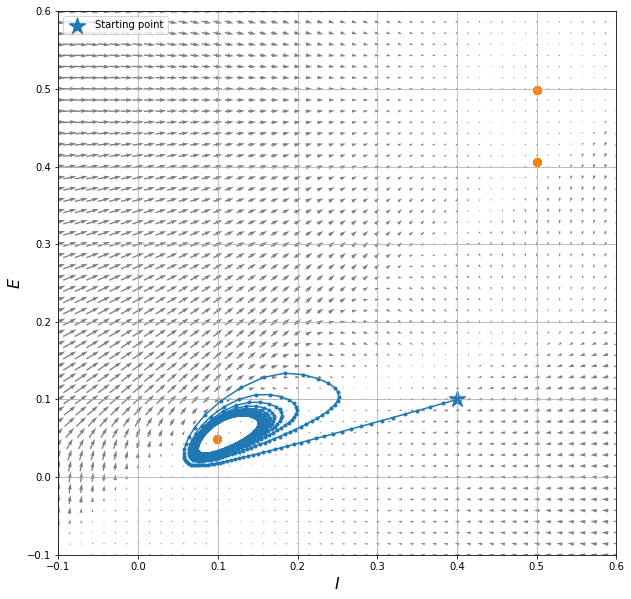

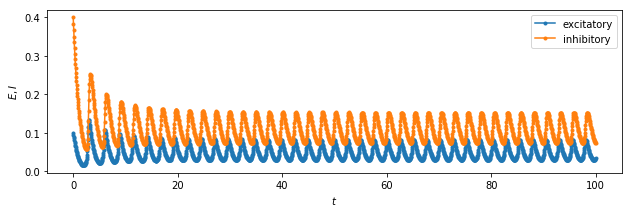

In [18]:
# plotting the vector field in the state space (E, I)
plt.figure(figsize=(10, 10))
plt.quiver(x2, x1, X2, X1, pivot='mid', alpha=.5)
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.xlabel(r'$I$', fontsize=16) # yes, you can use Latex code!
plt.ylabel(r'$E$', fontsize=16)
plt.grid()

# plot the solution in the state space
plt.plot(inh_timeseries, exc_timeseries, '.-');

# plot the starting point
plt.scatter(I0, E0, marker='*', s=300, label="Starting point")
plt.legend(loc="upper left")

# plot the fixed points we identified
plt.scatter(fixed_p[1], fixed_p[0], marker='o', s=50, label="Stationary points")

# plot the solution in time
plt.figure(figsize=(10.3,3))
plt.ylabel(r'$E, I$')
plt.xlabel(r'$t$')
plt.plot(time, exc_timeseries, '.-', label="excitatory");
plt.plot(time, inh_timeseries, '.-', label="inhibitory");
plt.legend();

We can see the system exhibits:
 - a **stable** stationary point at (0.5, 0.5)
 - an **unstable** stationary point at (0.5, 0.4)
 - a **limit cycle** about the stationary point at (0.1, 0.05)
 
The different nature of the stationary point, and the consequent influence they have on the behaviour of the solution in their neighbourhood, is due to the eigenvalues of the system when linearised near that point. Refer to a textbook for that!